In [9]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("/home/sambray/Documents/MS_analysis_samsplaying/")
from AnalysisTables.location_times import LocationTimesParams, LocationTimesSelection, LocationTimes
import numpy as np
from spyglass.position.position_merge import PositionOutput

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Populate

In [2]:
LocationTimesParams()

params_name = "ms_wtrack_2023_choice_point"
centers = [np.array([68, 125])]
radii = [20]
params_key = {"location_params_name": params_name, "centers": centers, "radii": radii}
LocationTimesParams().insert1(params_key, skip_duplicates=True)

params_name = "ms_wtrack_choice_point"
centers = [np.array([85, 120])]
radii = [20]
params_key = {"location_params_name": params_name, "centers": centers, "radii": radii}
LocationTimesParams().insert1(params_key, skip_duplicates=True)

In [3]:
# dlc_key = {'dlc_si_cohort_centroid': 'WhiteLED', 'nwb_file_name': 'Bilbo20230802_.nwb', 'epoch': 2, 'video_file_num': 1, 'project_name': 'Wtrack_WhiteLED_FB', 'dlc_model_name': 'Wtrack_WhiteLED_FB_wtrack_whiteled_FB_01', 'dlc_model_params_name': 'default', 'dlc_centroid_params_name': 'whiteLED_centroid_smooth_interp_fixed2', 'dlc_si_cohort_orientation': 'WhiteLED', 'dlc_orientation_params_name': 'none'}
PositionOutput().DLCPosV1() & {"project_name": "Wtrack_WhiteLED_FB"}
for merge_key in (
    PositionOutput().DLCPosV1() & {"project_name": "Wtrack_WhiteLED_FB"}
).fetch("KEY"):
    insert_key = {**merge_key, "location_params_name": "ms_wtrack_2023_choice_point"}
    LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

PositionOutput().DLCPosV1() & {"project_name": "Wtrack_WhiteLED"}
for merge_key in (
    PositionOutput().DLCPosV1() & {"project_name": "Wtrack_WhiteLED"}
).fetch("KEY"):
    insert_key = {**merge_key, "location_params_name": "ms_wtrack_choice_point"}
    LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

# merge_key = (PositionOutput().DLCPosV1() & dlc_key).fetch1("KEY")
# insert_key = {**merge_key,"location_params_name": params_name}
# LocationTimesSelection.insert1(insert_key, skip_duplicates=True)

In [22]:
LocationTimes().populate()

{'success_count': 88, 'error_list': []}

[[1.4000022411346436],
 [0.7999868392944336],
 [2.799973249435425],
 [1.0666530132293701],
 [0.866657018661499],
 [0.9999983310699463],
 [0.9999980926513672],
 [0.7999858856201172],
 [0.6999900341033936],
 [0.8333320617675781],
 [0.8666565418243408],
 [0.90000319480896],
 [0.8666565418243408],
 [0.8999814987182617],
 [0.8999829292297363],
 [0.833331823348999],
 [0.7666614055633545],
 [0.7666614055633545],
 [1.033323049545288],
 [0.7666594982147217],
 [0.9333248138427734],
 [0.8333320617675781],
 [0.9333271980285645],
 [0.7999861240386963],
 [0.69999098777771],
 [1.333310604095459],
 [0.8333323001861572],
 [0.6999897956848145],
 [0.7666609287261963],
 [0.7333147525787354],
 [1.0999975204467773],
 [0.7999861240386963],
 [0.6999905109405518],
 [0.7666666507720947],
 [2.0333261489868164],
 [3.3999648094177246],
 [0.9666523933410645],
 [1.266660213470459],
 [0.93332839012146],
 [1.0999948978424072],
 [0.8666572570800781],
 [5.499926805496216],
 [0.9999988079071045],
 [0.7333400249481201],
 

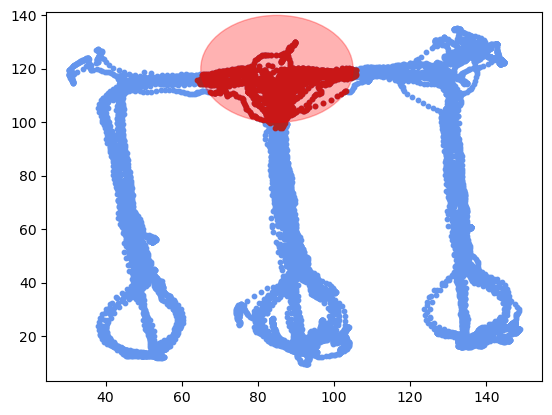

In [24]:
LocationTimes().validate_location(insert_key)

intervals = (LocationTimes() & insert_key).fetch1("intervals")
[[en - st] for st, en in intervals]

# Analyze

In [10]:
from Analysis.utils import filter_opto_data, violin_scatter
from spyglass.common import TaskEpoch, PositionIntervalMap
from Style.style_guide import animal_style
from spyglass.common import interval_list_intersect
import matplotlib.pyplot as plt
from AnalysisTables.trial_intervals import TrialIntervals

# from spyglass.position.v1 import

datasets: 42
control inbound: 1089
datasets: 44
transfected inbound: 1162
datasets: 42
control outbound: 1086
datasets: 44
transfected outbound: 1148


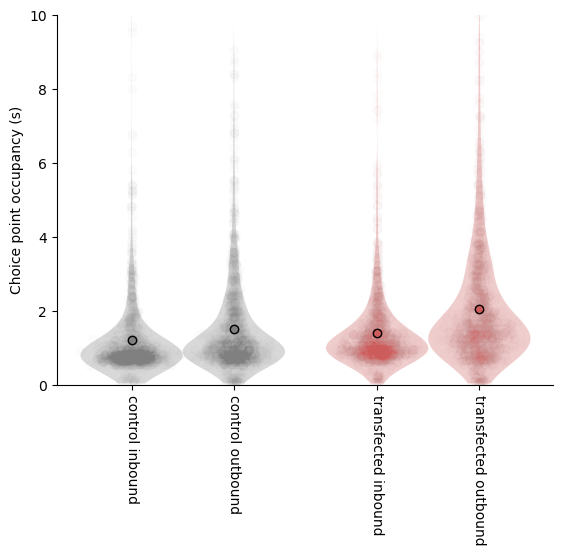

In [11]:
# animal = 'Bilbo'
animal_list = list(animal_style.index)
animal_list = [a for a in animal_list if a not in ["Odins", "control", "transfected"]]

animal_list = ["control", "transfected"]

pos_list = []
labels_list = []
fig = plt.figure()
ax = fig.add_subplot(111)
results = {animal: {} for animal in animal_list}
for i_trial, trial_type in enumerate(["inbound", "outbound"]):
    for i, animal in enumerate(animal_list):
        dataset_key = {"animal": animal, "track_type": "early_wtrack"}
        dataset = filter_opto_data(dataset_key)

        if not dataset:
            continue
        occupancy_lengths = []
        for key in dataset.fetch("KEY"):
            epoch_key = {
                "nwb_file_name": key["nwb_file_name"],
                "position_interval_name": key["interval_list_name"],
            }
            epoch = ((PositionIntervalMap() & epoch_key) * TaskEpoch()).fetch1("epoch")

            query = PositionOutput.DLCPosV1() & key & {"epoch": epoch}
            if not query:
                continue
            intervals = (LocationTimes() & query).fetch1("intervals")

            trial_query = TrialIntervals() & {
                "nwb_file_name": key["nwb_file_name"],
                "epoch": epoch,
            }
            trial_interval = None
            if trial_type == "outbound":
                # if not trial_query:
                #     continue
                trial_interval = trial_query.fetch1("outbound_trial_intervals")
            elif trial_type == "inbound":
                # if not trial_query:
                #     continue
                trial_interval = trial_query.fetch1("inbound_trial_intervals")

            if not len(trial_interval):
                continue
            intervals = interval_list_intersect(intervals, trial_interval)
            occupancy_lengths.extend([en - st for st, en in intervals])

        results[animal][trial_type] = occupancy_lengths
        pos = i * 1.2 + i_trial * 0.5
        violin_scatter(
            occupancy_lengths,
            pos=pos,
            color=animal_style.loc[animal, "color"],
            mark_mean=True,
        )
        print(f"{animal} {trial_type}: {len(occupancy_lengths)}")
        plt.scatter(
            [pos],
            [np.mean(occupancy_lengths)],
            color=animal_style.loc[animal, "color"],
            edgecolor="k",
            label=animal + " " + trial_type,
        )
        pos_list.append(pos)
        labels_list.append(animal + " " + trial_type)


plt.ylim(0, 10)
plt.xticks(pos_list, labels_list, rotation=-90)
plt.ylabel("Choice point occupancy (s)")
ax.spines[["top", "right"]].set_visible(False)

plt.rcParams["svg.fonttype"] = "none"
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/choice_point_occupancy.svg")
# fig.savefig("/home/sambray/Documents/MS_analysis_samsplaying/Figures_20241201/choice_point_occupancy_separate_animals.svg")

control inbound: [0.7   0.8   1.067]
control outbound: [0.767 1.033 1.7  ]
transfected inbound: [0.867 1.033 1.458]
transfected outbound: [1.    1.5   2.533]


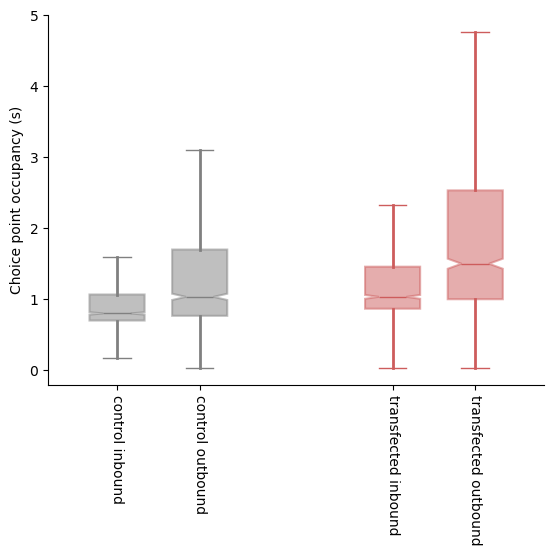

In [ ]:
x_locs = []
x_labels = []

fig, ax = plt.subplots()
for i, animal in enumerate(results):
    for j, trial_type in enumerate(results[animal]):
        c = animal_style.loc[animal, "color"]
        x = 2 * i + j * 0.6
        plt.boxplot(
            results[animal][trial_type],
            positions=[x],
            widths=0.4,
            patch_artist=True,
            showmeans=False,
            # showmedians=False,
            boxprops=dict(facecolor=c, alpha=0.5, edgecolor=c, lw=1.5),
            capprops=dict(color=c),
            whiskerprops=dict(color=c, lw=2),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            notch=True,
            showfliers=False,
        )
        print(
            f"{animal} {trial_type}: {np.round(np.percentile(results[animal][trial_type], [25,50,75]),3)}"
        )
        x_locs.append(x)
        x_labels.append(animal + " " + trial_type)
plt.xticks(x_locs, x_labels, rotation=-90)
plt.ylabel("Choice point occupancy (s)")
ax.spines[["top", "right"]].set_visible(False)
plt.rcParams["svg.fonttype"] = "none"
fig.savefig("./Figures_20250501/choice_point_occupancy_boxplot.svg")

### independent ttests

In [4]:
from scipy.stats import ttest_ind

for animal in results:
    print(animal + ": inbound vs outbound")
    print(
        ttest_ind(
            results[animal]["inbound"], results[animal]["outbound"], equal_var=False
        )[1]
    )

for trial_type in ["inbound", "outbound"]:
    print(trial_type + ": control vs transfected")
    print(
        ttest_ind(
            results["control"][trial_type],
            results["transfected"][trial_type],
            equal_var=False,
        )[1]
    )

control: inbound vs outbound
1.9788381784346803e-05
transfected: inbound vs outbound
1.4945074039237271e-21
inbound: control vs transfected
0.010072511211836192
outbound: control vs transfected
1.081720354456e-15


### Mixed linear model

In [ ]:
import statsmodels.api as sms
import pandas as pd

model_df = []
for i, animal in enumerate(results.keys()):
    for trial_type in ["inbound", "outbound"]:
        data = results[animal][trial_type]
        for d in data:
            model_df.append(
                {
                    "Animal": i,
                    "Treatment": (
                        "transfected"
                        if animal_style.loc[animal, "background"] == "indianred"
                        else "control"
                    ),
                    "Trial_Type": trial_type,
                    "Score": d,
                }
            )


model_df = pd.DataFrame(model_df)

from statsmodels.formula.api import mixedlm

# Convert the 'Treatment' column to a categorical variable
model_df["Treatment"] = model_df["Treatment"].astype("category")
model_df["Trial_Type"] = model_df["Trial_Type"].astype("category")
# model_df['Animal'] = model_df['Treatment'].astype('category')

# Fit the mixed-effects model
model = mixedlm("Score ~ Treatment * Trial_Type", model_df, groups=model_df["Animal"])
result = model.fit()

# Print the summary of the model
print(result.summary())
result.pvalues

                         Mixed Linear Model Regression Results
Model:                        MixedLM           Dependent Variable:           Score     
No. Observations:             4485              Method:                       REML      
No. Groups:                   2                 Scale:                        2.6355    
Min. group size:              2175              Log-Likelihood:               -8543.4770
Max. group size:              2310              Converged:                    Yes       
Mean group size:              2242.5                                                    
----------------------------------------------------------------------------------------
                                                Coef. Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                       1.218    1.624 0.750 0.453 -1.965  4.401
Treatment[T.transfected]                       

/home/sambray/mambaforge-pypy3/envs/spyglass/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


Intercept                                          0.453248
Treatment[T.transfected]                           0.938117
Trial_Type[T.outbound]                             0.000027
Treatment[T.transfected]:Trial_Type[T.outbound]    0.000139
Group Var                                               NaN
dtype: float64

# Velocity Distributions in choice point

In [48]:
animal_list = animal_style.index
animal_list = [a for a in animal_list if a not in ["Odins", "control", "transfected"]]
animal_list = ["control", "transfected"]
results = {}
for i, animal in enumerate(animal_list):
    dataset_key = {"animal": animal, "track_type": "early_wtrack"}
    dataset = filter_opto_data(dataset_key)

    if not dataset:
        continue
    speeds = []
    for key in dataset.fetch("KEY"):
        epoch_key = {
            "nwb_file_name": key["nwb_file_name"],
            "position_interval_name": key["interval_list_name"],
        }
        epoch = ((PositionIntervalMap() & epoch_key) * TaskEpoch()).fetch1("epoch")

        query = PositionOutput().DLCPosV1() & key & {"epoch": epoch}
        if not query:
            continue
        intervals = (LocationTimes() & query).fetch1("intervals")

        pos_df = (DLCPosV1() & query).fetch1_dataframe()

        ind = interval_list_contains_ind(intervals, pos_df.index.values)
        print(ind.size / pos_df.index.size)

        speeds_i = pos_df.iloc[ind].speed.values
        speeds_i = speeds_i[~np.isnan(speeds_i)]
        speeds.extend(speeds_i)

        # break
    results[animal] = speeds
    # break

datasets: 42
0.025464949928469243
0.06427519743006291
0.08355972668148515
0.1466157322716023
0.017266372451116195
0.047425179476023246
0.05833746488183771
0.056642693872999944
0.09828270202706374
0.06664270110333767
0.06263356896268289
0.055216068835119064
0.10226212046340526
0.1108889193261197
0.0898246356494829
0.08537630247920179
0.10140338637400381
0.0475142444917223
0.051786316581480425
0.05440479161467432
0.05968498129905705
0.07240426961259984
0.06357811729916214
0.05009855453350854
0.04978772674642995
0.05109647929477064
0.1127856906260351
0.04788708961845608
0.05384359585434795
0.050064693300942674
0.05886243386243386
0.029985007496251874
0.035954310368669966
0.0539711490631736
0.05775673505551402
0.0495582848524025
0.05354929344682258
0.0462059019303306
0.040918384262584956
0.0486965617859994
0.04120871553315153
datasets: 44
0.08118343195266273
0.0963931718061674
0.12263967835851934
0.10195472967384411
0.09375344276743418
0.08863145815688096
0.09768936665373747
0.103341735100

([<matplotlib.axis.XTick at 0x7f818fd77af0>,
 [Text(0, 0, 'control'), Text(1, 0, 'transfected')])

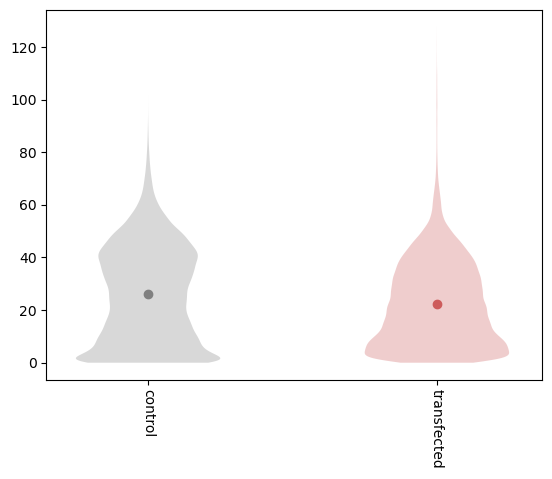

In [49]:
for i, (animal, speeds) in enumerate(results.items()):
    val = speeds
    # val = np.log10(val)
    violin_scatter(val, pos=i, color=animal_style.loc[animal, "color"], mark_mean=True)
# plt.yscale("log")
plt.xticks(range(len(results)), results.keys(), rotation=-90)

(3664,)


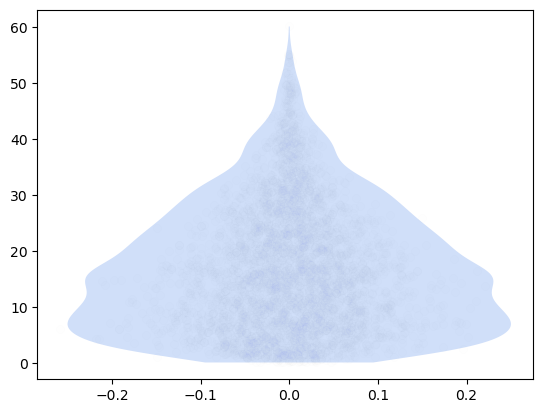

In [28]:
from spyglass.position.v1 import DLCPosV1
from spyglass.common import interval_list_contains_ind

pos_df = (DLCPosV1() & query).fetch1_dataframe()

ind = interval_list_contains_ind(intervals, pos_df.index.values)

speeds = pos_df.iloc[ind].speed.values
speeds = speeds[~np.isnan(speeds)]
print(speeds.shape)
violin_scatter(speeds)